In [46]:
%load_ext autoreload
%autoreload 2

import torch
from torch import nn
import torchvision.datasets as datasets
import torchvision.models as models
import torch.optim as optim
from torch.utils.data import DataLoader

import sys
sys.path.append('./python_files/')
import pickle

from model_trainer import ModelTrainer
from utils import *
from data_loader import *
from nn_modules import View
from nn_models import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [19]:
print("pytorch version: ",torch.__version__)

pytorch version:  0.5.0a0


In [20]:
if torch.cuda.is_available():
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
    print("Using GPU: ",torch.cuda.get_device_name(0))

Using GPU:  GeForce GTX 1080 Ti


## Loading the data (MNIST)

In [80]:
train_input, train_target, test_input, test_target = load_data(cifar=False, normalize=True, flatten=False, full=True)

train_target = train_target.long()
test_target = test_target.long()

* Using MNIST
** Use 60000 train and 10000 test samples


In [81]:
print("# of training samples : "+str(len(train_input)))

# of training samples : 60000


In [82]:
train_target[0].type()

'torch.cuda.LongTensor'

In [83]:
train_input.shape

torch.Size([60000, 1, 28, 28])

In [84]:
nb_sample = 500
train_input = train_input[0:nb_sample]
train_target = train_target[0:nb_sample]

test_input = test_input[0:nb_sample]
test_target = test_target[0:nb_sample]

In [85]:
computeClassesWeights(train_target)

tensor([0.1000, 0.1320, 0.1040, 0.1000, 0.1040, 0.0780, 0.0900, 0.1040, 0.0780,
        0.1100])

In [86]:
computeClassesWeights(test_target)

tensor([0.0840, 0.1340, 0.1100, 0.0900, 0.1100, 0.1000, 0.0860, 0.0980, 0.0800,
        0.1080])

## 1) LeNet with disjoint trainset and testset

In [87]:
train_dataset = (train_input, train_target)
test_dataset = (test_input, test_target)

In [88]:
crossEntropyClassesWeigths = computeClassesWeights(train_target)

In [89]:
class LeoNet(nn.Module):
    def __init__(self):
        super(LeoNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 128, kernel_size = 5)
        self.mxp1 = nn.MaxPool2d(kernel_size = 2)
        self.conv2 = nn.Conv2d(128, 64, kernel_size = 4)
        self.mxp2 = nn.MaxPool2d(kernel_size = 2)
        self.conv3 = nn.Conv2d(64, 64, kernel_size = 3)
        self.view = View([-1])
        self.fc1 = nn.Linear(256, 128)
        self.fc2 = nn.Linear(128, 32)
        self.fc3 = nn.Linear(32, 10)

    def forward(self, x):
        x = F.relu(self.mxp1(self.conv1(x)))
        x = F.relu(self.mxp2(self.conv2(x)))
        x = F.relu(self.conv3(x))
        x = self.view(x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [104]:
class LeoNet(nn.Module):
    def __init__(self):
        super(LeoNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size = 5)
        self.mxp1 = nn.MaxPool2d(kernel_size = 3)
        self.conv2 = nn.Conv2d(16, 4, kernel_size = 5)
        self.mxp2 = nn.MaxPool2d(kernel_size = 2)
        self.view = View([-1])
        self.fc1 = nn.Linear(16, 32)
        self.fc2 = nn.Linear(32, 10)

    def forward(self, x):
        x = F.relu(self.mxp1(self.conv1(x)))
        x = F.relu(self.mxp2(self.conv2(x)))
        x = self.view(x)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [105]:
model = LeoNet()
load_from_memory = True

In [106]:
#debug_layers_dims(model, train_input.shape)

******************************** Train log ************************************
                     train loss       train acc        val loss         val acc
0                    2.30456448           0.100      2.29399228           0.178
1000                 0.00463970           1.000      0.71179438           0.840
2000                 0.00108504           1.000      0.80073291           0.846
3000                 0.00054305           1.000      0.83910745           0.848
4000                 0.00035076           1.000      0.86856836           0.850
5000                 0.00025451           1.000      0.89125776           0.848
6000                 0.00019731           1.000      0.90927583           0.850
7000                 0.00015998           1.000      0.92431229           0.850
8000                 0.00013391           1.000      0.93695223           0.852
9000                 0.00011453           1.000      0.94770622           0.852
10000                0.00009978         

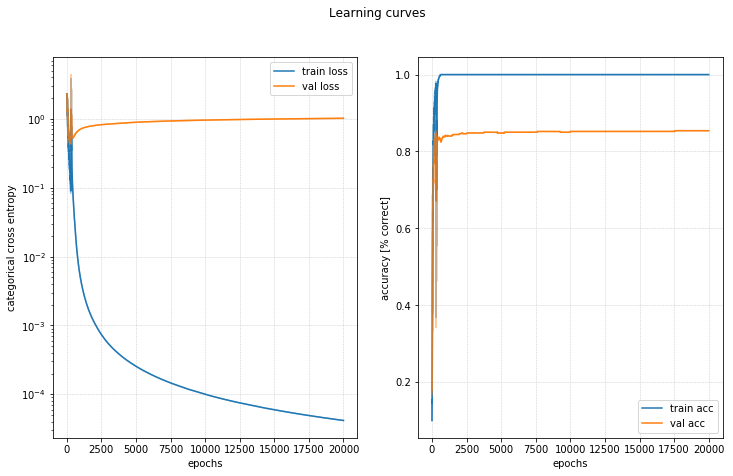

In [107]:
if not load_from_memory:
    crit_fun = lambda input_, target : (input_, target)
    y_hat_fun = lambda y: y.argmax(1)
    batch_cap = 60
    batch_fun = lambda x, y: x - 2*(y // batch_cap) * batch_cap

    loss_fun = nn.CrossEntropyLoss(weight=crossEntropyClassesWeigths)
    learning_rate = 0.05

    mt = ModelTrainer(model, loss_fun, optim.SGD(model.parameters(), lr=learning_rate), y_hat_fun, crit_fun)
    hist = mt.fit(train_dataset, test_dataset, epochs=20000, batch_size=500, verbose=1000)
    mt.plot_training("Learning curves")

In [108]:
if not load_from_memory:
    save_model_state(model, 'model_F.pickle')

In [109]:
if load_from_memory:
    load_model_state(model, 'model_F.pickle')

## 2) Extract layers activations examples

In [44]:
model.eval()

LeNet(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=256, out_features=200, bias=True)
  (fc2): Linear(in_features=200, out_features=10, bias=True)
)

In [73]:
#Can use the handle to remove the hook, don't execute twice on 
#the same handle, or you won't be able to remove the first
#instance of the hook
output_d, handles_d  = spyOn([model.conv2, model.fc1], ['convolution 2', 'FC_1'], True)

In [74]:
model(train_input[0:10].reshape(-1, 1, 28, 28))

captured output at layer : Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
captured output at layer : Linear(in_features=256, out_features=200, bias=True)


tensor([[ -1.1261,   0.2319,  -2.2108,   8.2289,  -8.8106,  13.9956,  -5.1217,
          -4.9852,   4.3573,  -1.5158],
        [ 16.1048,  -5.2382,   1.3853,  -3.6267,  -7.9822,   2.5762,   1.2530,
           1.2929,  -5.4332,   3.9208],
        [ -6.9658,  -0.2990,   3.6982,   1.3166,  12.7887,  -3.0896,  -2.0600,
           2.0811,  -5.5891,   3.5318],
        [ -4.2202,  16.6430,   5.7847,  -4.7326,  -0.7825,  -9.9602,  -1.6584,
           4.1487,   3.8827,  -6.1504],
        [ -7.4407,  -1.0903,  -3.7515,  -1.2637,   7.1777,  -2.8158,  -7.9753,
           2.3371,   5.4118,  16.4798],
        [  1.9087,  -3.1865,  11.0889,   2.2133,  -8.3201,  -1.6184,  -2.6984,
           0.3635,   4.1818,   1.9694],
        [ -7.7393,  11.7036,   2.5693,  -0.2030,  -0.7769,  -1.3100,   0.1971,
           0.0766,   3.9108,  -2.7437],
        [ -0.8917,  -4.6641,   4.4691,  19.9583, -11.5973,   3.9280, -12.2253,
          -2.5459,   6.0714,   3.7880],
        [ -6.5266,  11.3777,   0.5818,  -2.0877,

In [75]:
output_d['convolution 2'].reshape(10, -1).shape

torch.Size([10, 1024])

In [76]:
remove_spying(handles_d)

## 3) Differentiate layer activation from training sample than one from a testing sample (per classes)

In [102]:
model.eval()

LeoNet(
  (conv1): Conv2d(1, 8, kernel_size=(5, 5), stride=(1, 1))
  (mxp1): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(8, 4, kernel_size=(5, 5), stride=(1, 1))
  (mxp2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (view): View(_, [-1])
  (fc1): Linear(in_features=16, out_features=16, bias=True)
  (fc2): Linear(in_features=16, out_features=10, bias=True)
)

In [103]:
layer = model.conv2
layer_name = "conv2"

In [104]:
g_train_dataset_classes, g_test_dataset_classes = \
generate_dataset_g_per_class(model, train_dataset, test_dataset, [layer], [layer_name], split=0.7) 

In [105]:
def kindaResnetG(layer_dim):
    dim = layer_dim[2]
    pad = (1, 1, 1)
    pool = 1
    finalVectorSize = layer_dim[2]//pool * layer_dim[3]//pool * layer_dim[4]//pool
    model = nn.Sequential(
        nn.Conv3d(1, 1, kernel_size=3, padding = pad),
        nn.ReLU(),
        #nn.BatchNorm3d(1),
        nn.Conv3d(1, 1, kernel_size=3, padding = pad),
        nn.ReLU(),
        #nn.BatchNorm3d(1),
        nn.Conv3d(1, 1, kernel_size=3, padding = pad),
        nn.ReLU(),
        #nn.BatchNorm3d(1),
        #nn.Conv3d(1, 1, kernel_size=3, padding = pad),
        #nn.ReLU(),
        #nn.MaxPool3d(pool),

        View([-1]),
        nn.Linear(finalVectorSize, 1024),
        nn.ReLU(),
        #nn.Linear(64, 128),
        #nn.ReLU(),
        nn.Linear(1024, 256),
        nn.ReLU(),
        nn.Linear(256, 64),
        nn.ReLU(),
        nn.Linear(64, 2),  
    )
    return model


In [106]:
choosen_class = 4
g_train_dataset = g_train_dataset_classes[choosen_class]
g_test_dataset = g_test_dataset_classes[choosen_class]

In [110]:
size_input_vector = g_train_dataset[0].shape
print("size of layer vector :", size_input_vector)

size of layer vector : torch.Size([74, 1, 4, 4, 4])


In [111]:
g_target_weigths = torch.abs(1-computeClassesWeights(g_train_dataset[1]))
g_target_weigths

tensor([0.4865, 0.5135])

******************************** Train log ************************************
                     train loss       train acc        val loss         val acc
0                    0.00936278           0.514      0.02092019           0.515
20                   0.00774535           0.743      0.02063436           0.576
40                   0.00400069           0.892      0.02566039           0.636
60                   0.00071842           1.000      0.04335740           0.545
80                   0.00004752           1.000      0.06751439           0.576
100                  0.00001295           1.000      0.07696101           0.606
120                  0.00000762           1.000      0.08107331           0.606
140                  0.00000545           1.000      0.08386234           0.606
160                  0.00000410           1.000      0.08613125           0.606
180                  0.00000313           1.000      0.08828547           0.606
200                  0.00000241         

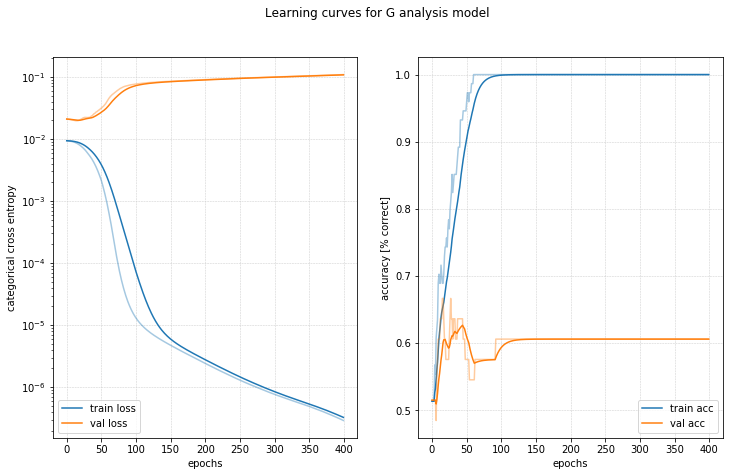

In [115]:
modelG = kindaResnetG(size_input_vector)

crit_fun = lambda input_, target : (input_, target)
y_hat_fun = lambda y: y.argmax(1)

loss_fun = nn.CrossEntropyLoss()#g_target_weigths)
learning_rate = 0.001

mt = ModelTrainer(modelG, loss_fun, optim.Adamax(modelG.parameters(), lr=learning_rate), y_hat_fun, crit_fun)
hist = mt.fit(g_train_dataset, g_test_dataset, epochs=400, batch_size=100, verbose=20)
mt.plot_training("Learning curves for G analysis model")

In [129]:
sum(x.numel() for x in modelG.parameters())

42498

## 4) Train 10 shadow F models

In [20]:
model.eval()

LeNet(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=256, out_features=200, bias=True)
  (fc2): Linear(in_features=200, out_features=10, bias=True)
)

In [22]:
(shadow_train_datasets, shadow_test_datasets) = generate_n_shadow_models_datasets(10, train_dataset, test_dataset)

training shadow model [0] ...done !
training shadow model [1] ...done !
training shadow model [2] ...done !
training shadow model [3] ...done !
training shadow model [4] ...done !
training shadow model [5] ...done !
training shadow model [6] ...done !
training shadow model [7] ...done !
training shadow model [8] ...done !
training shadow model [9] ...done !


SyntaxError: 'return' outside function (<ipython-input-26-8b3f6dc78f23>, line 28)

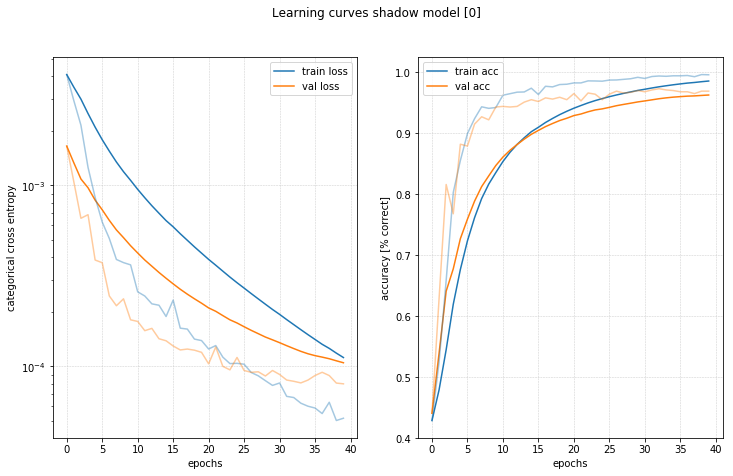

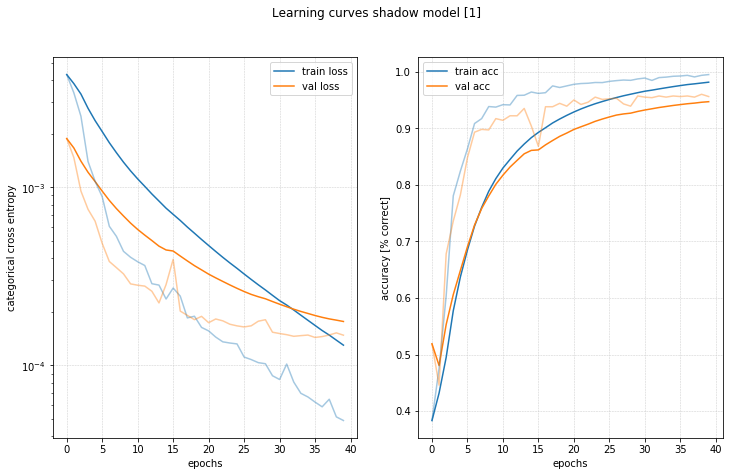

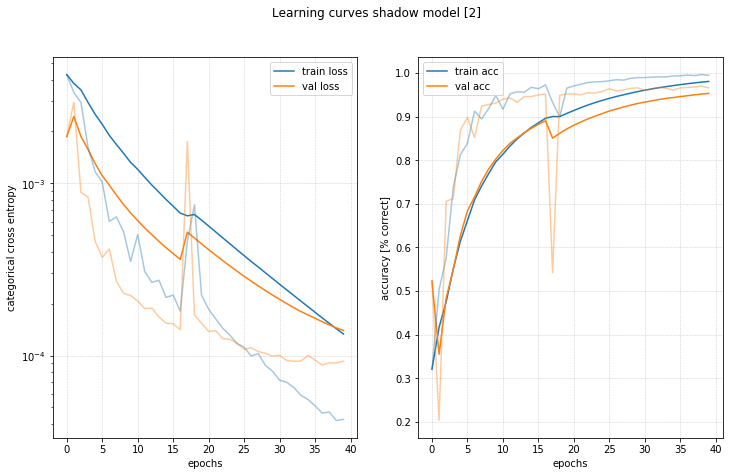

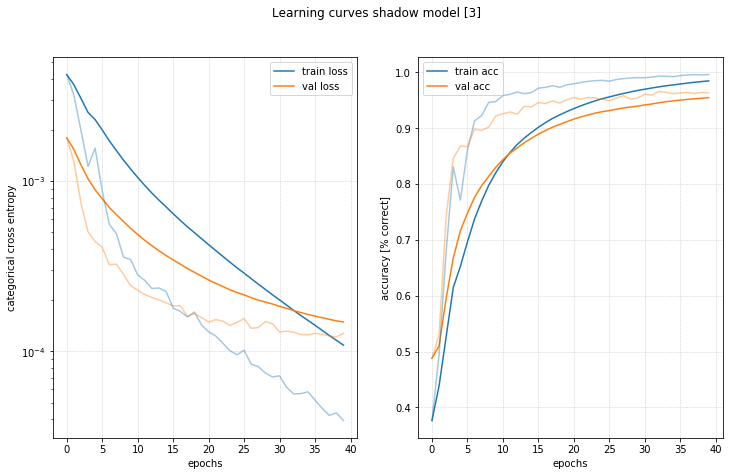

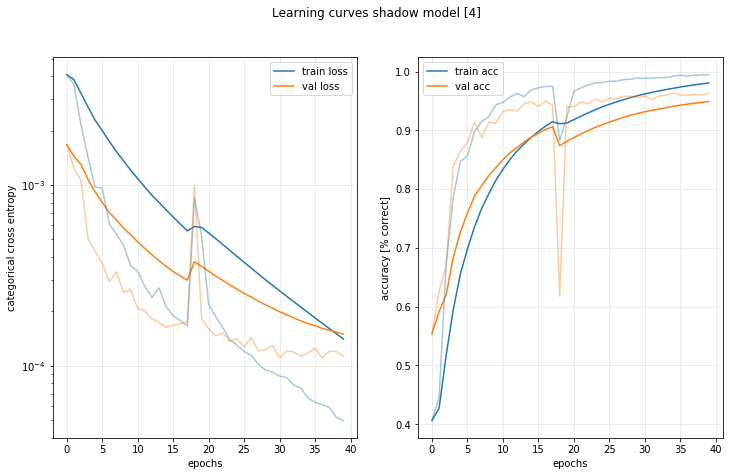

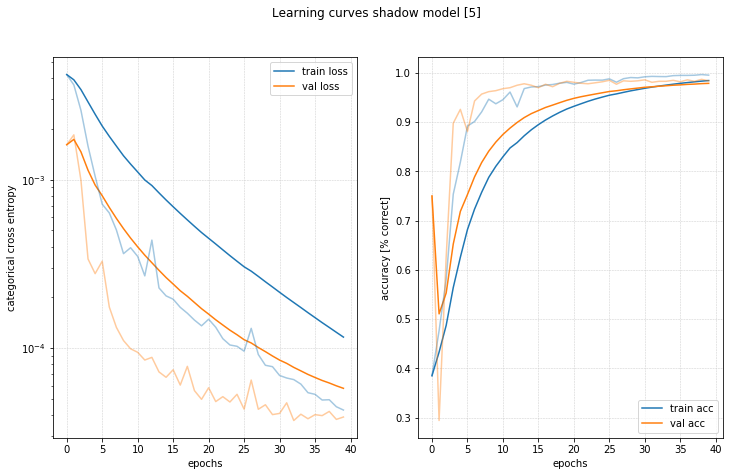

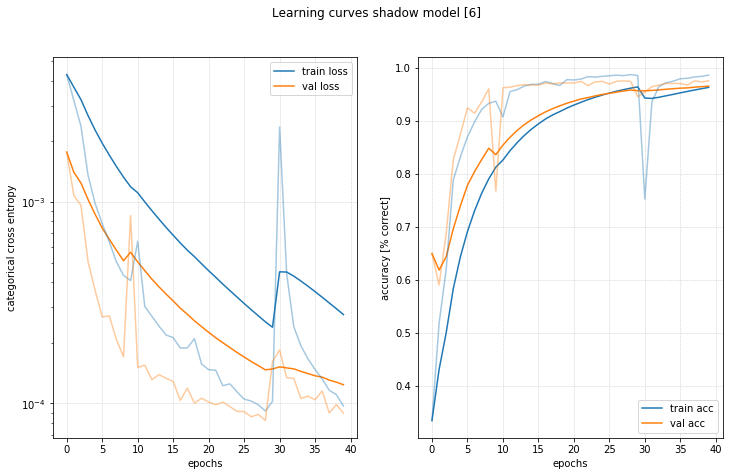

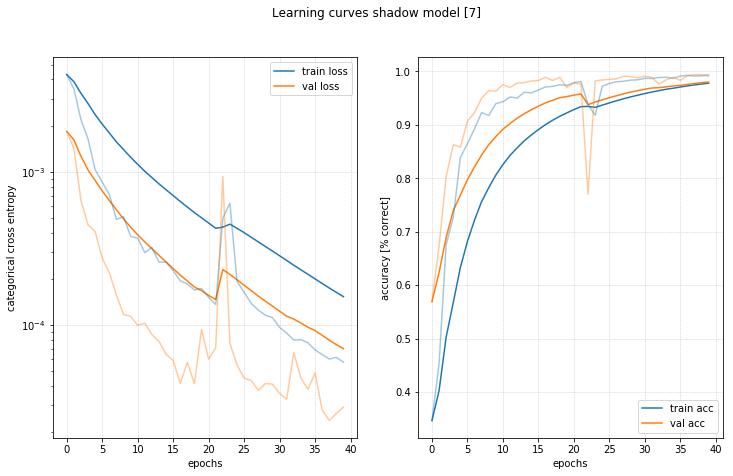

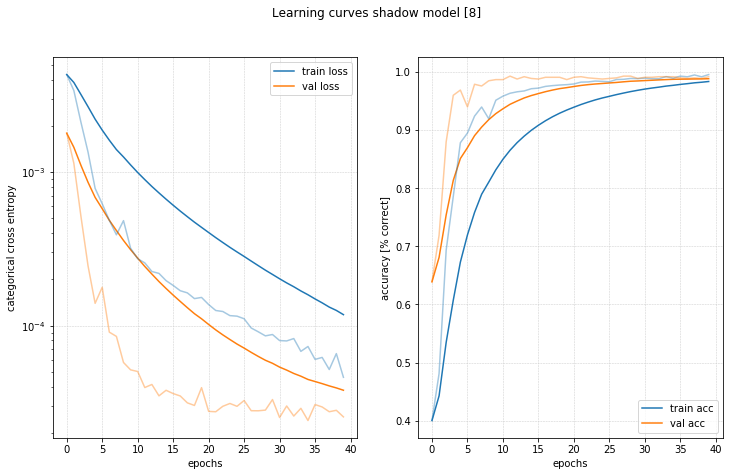

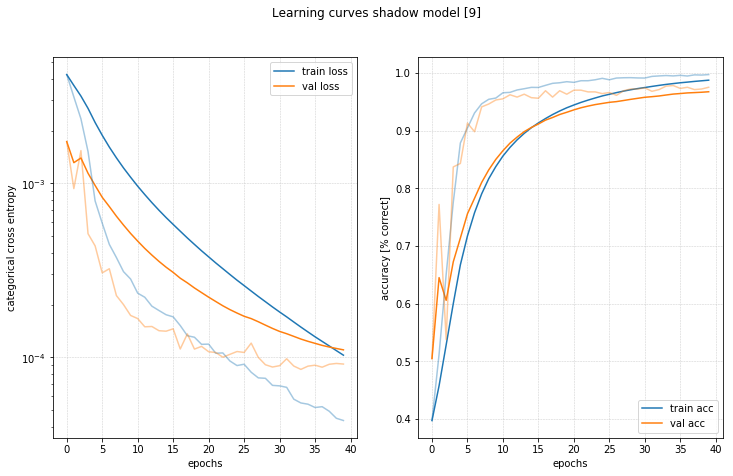

In [26]:
#Define training parameters
crit_fun = lambda input_, target : (input_, target)
y_hat_fun = lambda y: y.argmax(1)
learning_rate = 0.1
nb_epochs = 40
batch_size = 500
verbose = 0

#create the shadow models
model_class = LeNet
shadow_models = list()
for i in range(10):
    shadow_models.append(model_class())
    
#train the shadow models
for i in range(10):
    print("training shadow model ["+str(i)+"] ...", end='')

    crossEntropyClassesWeigths = computeClassesWeights(shadow_train_datasets[i][1])

    loss_fun = nn.CrossEntropyLoss(weight=crossEntropyClassesWeigths)

    mt = ModelTrainer(shadow_models[i], loss_fun, optim.SGD(shadow_models[i].parameters(), lr=learning_rate), y_hat_fun, crit_fun)
    hist = mt.fit(shadow_train_datasets[i], shadow_test_datasets[i], epochs=nb_epochs, batch_size=batch_size, verbose=verbose)
    mt.plot_training("Learning curves shadow model ["+str(i)+"]")
    print("done !")


In [27]:
for i in range(10):
    shadow_models[i].eval()

## 5) (REPORT TO LATER) Generate shadow G datasets per classes

In [23]:
shadow_layers = list()
shadow_layers_names = list()
for i in range(10):
    shadow_layers.append(models[i].conv2)
    shadow_layers_names.append("shadow model ["+str(i)+"] layer conv2")

In [24]:
split = 0.7

shadow_g_train_input = train_input.new()
shadow_g_train_target = train_target.new()
shadow_g_test_input = test_input.new()
shadow_g_test_target = test_target.new()

for i in range(10):
    (tmp_g_train_input, tmp_g_train_target), (tmp_g_test_input, tmp_g_test_target) = \
    generate_dataset_g(models[i], shadow_train_datasets[i], shadow_test_datasets[i], [shadow_layers[i]], [shadow_layers_names[i]], split=split)
    
    shadow_g_train_input = torch.cat((shadow_g_train_input,tmp_g_train_input))
    shadow_g_train_target = torch.cat((shadow_g_train_target,tmp_g_train_target))
    
    shadow_g_test_input = torch.cat((shadow_g_test_input,tmp_g_test_input))
    shadow_g_test_target = torch.cat((shadow_g_test_target,tmp_g_test_target))
    
shadow_g_train_dataset = (shadow_g_train_input, shadow_g_train_target)
shadow_g_test_dataset = (shadow_g_test_input, shadow_g_test_target)

In [25]:
shadow_g_train_input.shape

torch.Size([14000, 1, 1024])

In [71]:
unique_classes = torch.unique(shadow_g_train_target)

In [78]:
shadow_g_train_input[shadow_g_train_target == 1].shape

torch.Size([7000, 1, 1024])